In [16]:
# 2D CFD Solver for Euler Equations of Airflow over Inclined Flat Plate
# Incompressible, Laminar, Steady-State, Finite Volume Method
# Time Schemes: Forward Euler
# Solution Schemes: Central Difference, First-Order Upwind

# Author: Jared Crebo, 2025

# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from cell import cell

# Parameters of Inclined Flat Plate
plate_incline = 30 # degrees
plate_length = 0.5 # meters

# Parameters of Flow
airspeed = 5 # m/s
density = 1.225 # kg/m^3

# Parameters of Domain
domain_x = plate_length * 10 # meters
domain_y = plate_length * 4 # meters
nx = 50 # Number of Nodes in x-direction
ny = 20 # Number of Nodes in y-direction
cx = nx - 1 # Number of Cells in x-direction
cy = ny - 1 # Number of Cells in y-direction
cell_length_x = domain_x / nx # Length of Cell in x-direction
cell_length_y = domain_y / ny # Length of Cell in y-direction
timestep = 0.01 # seconds



In [3]:
# Generate Structured Mesh with nx x ny Cells
def mesh_generation():
    # Generate Mesh Nodes
    x = np.linspace(-domain_x / 2, domain_x / 2, nx)
    y = np.linspace(-domain_y / 2, domain_y / 2, ny)
    nodes_x, nodes_y = np.meshgrid(x, y)

    # Calculate Cell Centers
    #xc = 0.5 * (nodes_x[1:, 1:] + nodes_x[:-1, :-1])
    xc = np.empty(cx)
    yc = np.empty(cy)
    for i in range(cx):
        xc[i] = x[i] + 0.5 * cell_length_x
    for j in range(cy):
        yc[j] = y[j] + 0.5 * cell_length_y
    #yc = 0.5 * (nodes_y[1:, 1:] + nodes_y[:-1, :-1])
    centers_x, centers_y = np.meshgrid(xc, yc)

    # Generate Mesh Cell Objects
    mesh = np.empty((cx, cy), dtype=cell)
    for i in range(cx):
        for j in range(cy):
            mesh[i,j] = cell(centers_x[j,i], centers_y[j,i], domain_x, domain_y, nx, ny)
    
    # Assign Cell Neighbours for Each Cell Object
    for i in range(cx):
        for j in range(cy):
            Cell = mesh[i,j]
            if j < cy-1:
                north = [i,j+1]
            else:
                north = None
            if j > 0:
                south = [i,j-1]
            else:
                south = None
            if i < cx-1:
                east = [i+1,j]
            else:
                east = None
            if i > 0:
                west = [i-1,j]
            else:
                west = None
            cell.set_neighbours(Cell, north, south, east, west)
    
    return nodes_x, nodes_y, centers_x, centers_y, mesh

nodes_x, nodes_y, centers_x, centers_y, mesh = mesh_generation()



In [4]:
def check_variables():
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlim(-domain_x / 2, domain_x / 2)
    ax.set_ylim(-domain_y / 2, domain_y / 2)
    for i in range(cx):
        for j in range(cy):
            rect = patches.Rectangle(xy=(nodes_x[j,i], nodes_y[j,i]), width=mesh[i,j].length_x, height=mesh[i,j].length_y, 
                    linewidth=1, edgecolor='darkgrey', facecolor='white')
            ax.add_patch(rect)
            variable = str(i)+", "+str(j)
            ax.annotate(str(variable), (mesh[i,j].Xc, mesh[i,j].Yc), color='black', fontsize=8, ha='center', va='center')


In [5]:
# Set Boundary Conditions on Outer Bounds of Domain
def set_boundary_conditions():
    # Vertical Boundaries
    for j in range(cy):
        # Inlet Boundary Condition (Left Wall)
        mesh[0,j].is_boundary = True
        mesh[0,j].boundary_type = "inlet"
        
        # Outlet Boundary Condition (Right Wall)
        mesh[cx-1,j].is_boundary = True
        mesh[cx-1,j].boundary_type = "outlet"
    
    # Horizontal Boundaries
    for i in range(cx):
        # Lower Freestream Boundary Condition (Bottom Wall)
        mesh[i,0].is_boundary = True
        mesh[i,0].boundary_type = "freestream"

        # Upper Freestream Boundary Condition (Top Wall)
        mesh[i,cy-1].is_boundary = True
        mesh[i,cy-1].boundary_type = "freestream"

set_boundary_conditions()

In [6]:
# Return Index of Cell in (x,y) Location
def locate_cell_index(x, y):
    index_x = 0
    index_y = 0
    for i in range(cx-1):
        if x <= nodes_x[0,i+1] and x >= nodes_x[0,i]:
            index_x = i
    for j in range(cy-1):
        if y <= nodes_y[j+1,0] and y >= nodes_y[j,0]:
            index_y = j
    return index_x, index_y

# Set Boundary Conditions on Object in Flow
def set_object():
    # Starting Point (0,0)
    mesh[locate_cell_index(0,0)].is_boundary = True
    mesh[locate_cell_index(0,0)].boundary_type = "noSlip"

    # Plate Boundary Conditions
    x = 0
    y = 0
    for i in range(0,int(plate_length/2 * 100),int(round(cell_length_x/2 * 100))):
        # Identify (x,y) Location of Plate
        x += cell_length_x * np.cos(np.deg2rad(plate_incline))
        y += cell_length_y * np.sin(np.deg2rad(plate_incline))

        # Identify Which Cell is at that Location and Set Boundary Condition
        a, b = locate_cell_index(x, y)
        mesh[a,b].is_boundary = True
        mesh[a,b].boundary_type = "noSlip"
        d, e = locate_cell_index(-x, -y)
        mesh[d,e].is_boundary = True
        mesh[d,e].boundary_type = "noSlip"

set_object()

In [7]:
def locate_cell_location(i, j):
    return mesh[i,j].Xc, mesh[i,j].Yc


In [8]:
def set_initial_conditions():
    for i in range(cx):
        for j in range(cy):
            if mesh[i,j].is_boundary == False:
                mesh[i,j].rho = density
                mesh[i,j].u = airspeed
                mesh[i,j].v = 0.0
                mesh[i,j].p = 0.0
            else:
                if mesh[i,j].boundary_type == "inlet" or mesh[i,j].boundary_type == "outlet" or mesh[i,j].boundary_type == "freestream":
                    mesh[i,j].rho = density
                    mesh[i,j].u = airspeed
                    mesh[i,j].v = 0.0
                    mesh[i,j].p = 0.0
                elif mesh[i,j].boundary_type == "noSlip":
                    mesh[i,j].rho = density
                    mesh[i,j].u = 0.0
                    mesh[i,j].v = 0.0
                    mesh[i,j].p = 0.0
                else:
                    print("Boundary Condition Error at [" + str(mesh[i,j].Xc) + "," + str(mesh[i,j].Yc) + "]")
set_initial_conditions()


In [9]:
def check_direction(cell, neighbour, direction):
    if neighbour != None:
        if direction == "N":
            return neighbour.Yc > cell.Yc
        elif direction == "S":
            return neighbour.Yc < cell.Yc
        elif direction == "E":
            return neighbour.Xc > cell.Xc
        elif direction == "W":
            return neighbour.Xc < cell.Xc
        else:
            print("Direction Error in check_direction()")
    else:
        return False

In [10]:
def get_face_velocity(cell, neighbour, direction):
    """
    Compute velocity at cell face
    Positive = flow exiting cell
    Negative = flow entering cell
    """
    face_velocity = 0.0
    if check_direction(cell, neighbour, direction):
        if direction == "N":
            face_velocity = 0.5 * (cell.v + neighbour.v)
        elif direction == "S":
            face_velocity = - 0.5 * (cell.v + neighbour.v)
        elif direction == "E":
            face_velocity = 0.5 * (cell.u + neighbour.u)
        elif direction == "W":
            face_velocity = - 0.5 * (cell.u + neighbour.u)
        else:
            print("Direction Error in get_face_velocity()")
    else:
        print("Direction Error in get_face_velocity()")
    return face_velocity

In [11]:
def compute_flux(cell, neighbour, direction, variable):
    """
    cell - current cell object
    neighbour - neighbouring cell object
    direction - direction of the face
    variable - flow variable
    """
    face_velocity = get_face_velocity(cell, neighbour, direction)
    area = cell.length_x * cell.length_y
    if variable == "momentum":
        if direction == "N" or direction == "S":
            if face_velocity >= 0: # Flow from current cell to neighbour
                phi = cell.v * cell.rho
            else:
                phi = neighbour.v * neighbour.rho
        elif direction == "E" or direction == "W":
            if face_velocity >= 0: # Flow from current cell to neighbour
                phi = cell.u * cell.rho
            else:
                phi = neighbour.u * neighbour.rho
        else:
            print("Direction Error in compute_flux()")
    elif variable == "mass":
        if direction == "N" or direction == "S":
            if face_velocity >= 0: # Flow from current cell to neighbour
                phi = cell.rho
            else:
                phi = neighbour.rho
        elif direction == "E" or direction == "W":
            if face_velocity >= 0: # Flow from current cell to neighbour
                phi = cell.rho
            else:
                phi = neighbour.rho
        else:
            print("Direction Error in compute_flux()")
    else:
        print("Variable Error in compute_flux()")
    flux = phi * face_velocity * area
    return flux

In [12]:
def get_neighbour(cell, direction):
    return cell.neighbours[direction]

print(get_neighbour(mesh[1,1], "N"))

[1, 2]


In [13]:
def compute_fluxes(cell):
    # Compute Mass and Momentum Fluxes Across a Face
    # First-Order Upwind Scheme
    directions = ["N", "S", "E", "W"]
    for direction in directions:
        # Cell Neighbour in Direction
        index = cell.neighbours[direction]
        
        if index is not None:
            neighbour = mesh[index[0], index[1]]
            cell.momentum_flux[direction] = compute_flux(cell, neighbour, direction, "momentum")
            cell.mass_flux[direction] = compute_flux(cell, neighbour, direction, "mass")

In [14]:
def update_cell_variables(cell):
    """
    Update flow variables in cell
    """
    # Compute Mass and Momentum Fluxes Across a Face
    # First-Order Upwind Scheme
    compute_fluxes(cell)

    # Update Flow Variables
    # Forward Euler Scheme
    if cell.is_boundary == False:
        cell.rho += timestep * (cell.mass_flux["N"] + cell.mass_flux["S"] + cell.mass_flux["E"] + cell.mass_flux["W"]) / cell.volume
        cell.u += timestep * (cell.momentum_flux["E"] + cell.momentum_flux["W"]) / cell.volume
        cell.v += timestep * (cell.momentum_flux["N"] + cell.momentum_flux["S"]) / cell.volume
    else:
        try:
            cell.rho += timestep * (cell.mass_flux["N"] + cell.mass_flux["S"] + cell.mass_flux["E"] + cell.mass_flux["W"]) / cell.volume
            cell.u += timestep * (cell.momentum_flux["E"] + cell.momentum_flux["W"]) / cell.volume
            cell.v += timestep * (cell.momentum_flux["N"] + cell.momentum_flux["S"]) / cell.volume
        except Exception as e:
            print("Error in update_cell_variables() at [" + str(cell.Xc) + "," + str(cell.Yc) + "]")


In [27]:
def assemble_matrix():
    A = np.zeros((cx*cy, cx*cy))
    b = np.zeros(cx*cy)
    
    neighbours = mesh[1,1].neighbours
    fluxes = mesh[1,1].mass_flux
    print(fluxes)

    for i in range(cx):
        for j in range(cy):
            neighbours = mesh[i,j].neighbours
            fluxes = mesh[i,j].mass_flux

            A[i+j,i+j] += -sum(fluxes.values())

            for direction, neighbour_flux in fluxes.items():
                if neighbours[direction] is not None:
                    A[i+j, neighbours[direction]] += neighbour_flux

            if mesh[i,j].is_boundary:
                if mesh[i,j].boundary_type == "inlet":
                    b[i+j] = density * airspeed * cell_length_y * cell_length_x
                
            

    return A, b
assemble_matrix()

{'N': 0.0, 'S': 0.0, 'E': 0.0, 'W': 0.0}


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [16]:
for i in range(cx):
    for j in range(cy):
        update_cell_variables(mesh[i,j])

4.954540764404297


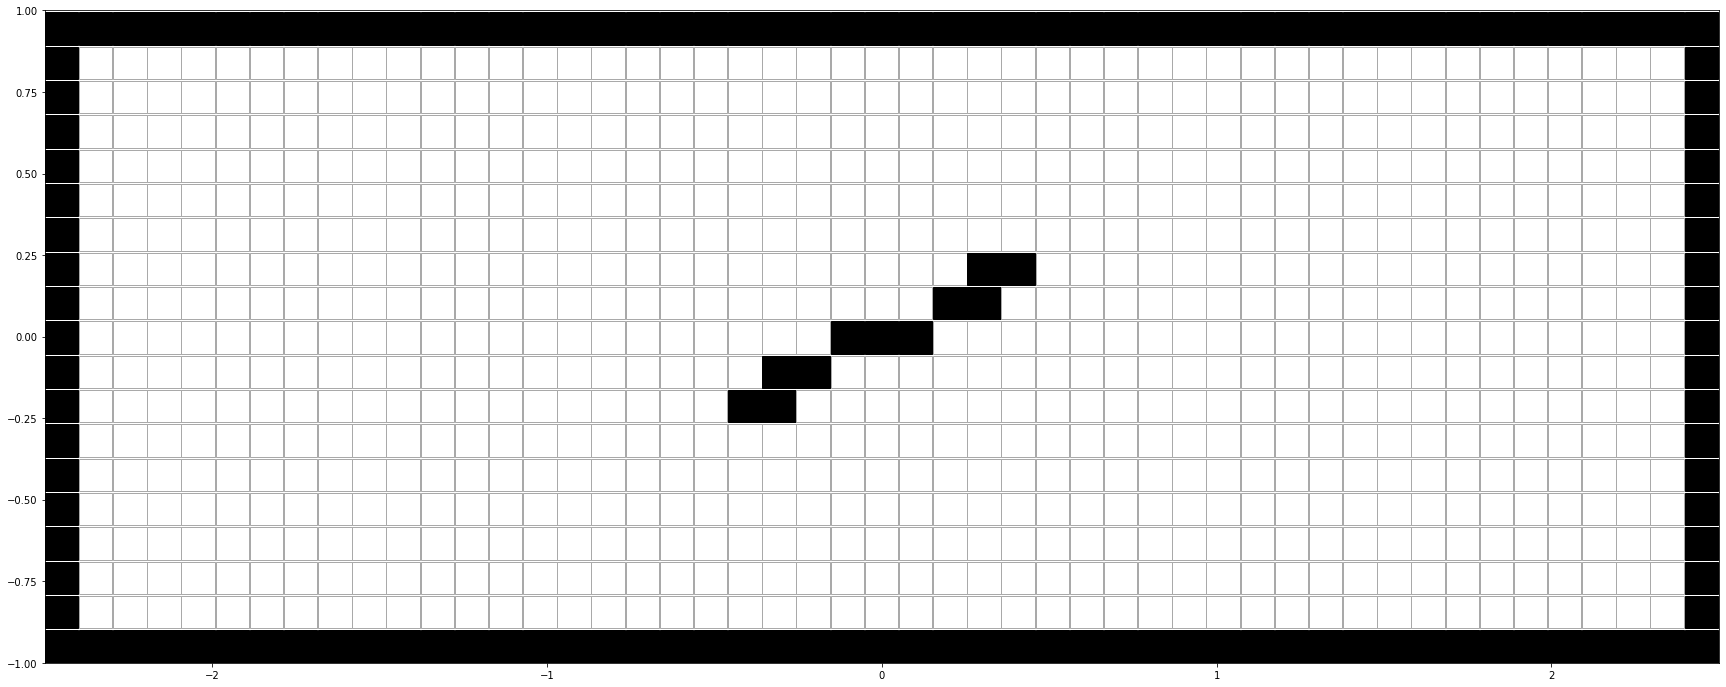

In [ ]:
# Plot Mesh
fig, ax = plt.subplots(figsize=(30, 12))
#plt.scatter(nodes_x, nodes_y, color='red', s=10, zorder=5, label="Grid points")
#plt.scatter(centers_x, centers_y, color='blue', s=10, zorder=5, label="Cell centers")
for i in range(cx):
    for j in range(cy):
        if mesh[i,j].is_boundary == True:
            rect = patches.Rectangle(xy=(nodes_x[j,i], nodes_y[j,i]), width=mesh[i,j].length_x, height=mesh[i,j].length_y, 
                                    linewidth=1, edgecolor='black', facecolor='black')
        else:
            rect = patches.Rectangle(xy=(nodes_x[j,i], nodes_y[j,i]), width=mesh[i,j].length_x, height=mesh[i,j].length_y, 
                                    linewidth=1, edgecolor='darkgrey', facecolor='white')
        ax.add_patch(rect)
ax.set_xlim(-domain_x / 2, domain_x / 2)
ax.set_ylim(-domain_y / 2, domain_y / 2)
plt.show()
